# Updated Logistic Regression
***

In this module I will:

- Review findings of the last update.
- Interpret the meaning of the clustered champion categoricals and provide more meaningful labels for each cluster.
- Create a new logistic regression model based on the newly interpretted clusters.
- Evaluate the quality of this new model.
- Create a list of team compositions from all combinations of the new champion categoricals.
- Group teamDF by these team compositions to see which perform most effectively in terms of win pct and gspd.
- Investigate which teams most frequently draft the most and least successful compositions.

If possible I will also:

- Run another round of t-SNE and kmeans clustering on the champion categorical updated team data to see if any natural groups of team types exist and how well each of them perform.
- Evaluate how many games can be considered 'close', to be used in an analysis where more of the original features can be retained.

**DISCLOSURE**: I realized while interpretting the meaning of clustered champion categoricals that I forgot to include 'waterdrakes' in my list of leak features in last week's update. This unfortunately led to a feature I had not intended to include being a major determinant of cluster assignment for junglers. So I reran the t-SNE implementations from last week with the correct features and have loaded the results of that into this notebook.

In [139]:
%store -r teamDF
%store -r playerDF

# k_players is a cleaned up copy of playerDF (fully NaN columns dropped, NaN row values imputed by mean or
# median depending on outlier concentration of feature).   
%store -r k_players

# position_dfs is a list of player position dataframes with features limited to the regressors, indexed by gameid and player
%store -r position_dfs

# tsne_data is a dictionary of t-SNE results for each player position and a set of different tuning parameters for sklearn's
# TSNE
%store -r tsne_data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from scipy import stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr

# Review Of Last Update

Last week I ran I series of t-SNE dimensionality reductions on a 'leak-free' view of each partition of the `k_players` dataframe, changing the tuning parameters of the t-SNE algorithm as I went and judging the results by which implementations resulted in the lowest KL Divergence values provided mean sigma stayed reasonable below 1. I discovered that the best results for all implementations came when the max iterations was set to 5k, the perplexity to 100, and the learning rate (for all but top lane) set to 1000.

I then examined the results in a scatterplot grid to identify the natural number of clusters in each partition, ran a round of kmeans clustering based on those observed numbers of clusters, and created another scatterplot grid showing the cluster assignments by color.

## Review of last update (cont'd)

Surprisingly, the observations were not clustered in a way I expected them to be from the t-SNE plots. Where I saw what I thought was a natural cluster of observations that I expected to share a color, kmeans disagreed.

After our meeting, I decided to play around with the clustering and visualizations to see what was going on (by tweaking values in the list `k_count` in the following code). I noticed that even though the clusters weren't being split into the bins I expected from the original plots, they were being consistently split (meaning, colors weren't arbitrarily being assigned all over the plots).

This is probably not a valid technique, but I decided to rerun my clustering and visualization code a few times, on each iteration raising the values of `k_count` until the point that colors started to appear assigned arbitrarily around the plots, and when I got to such a point, taking down that particular value by 1. The following is the result of that tinkering.

In [140]:
for df in position_dfs:
    df.drop(['result','cluster'], axis = 'columns', inplace = True, errors = 'ignore')

In [104]:
tsneDF = k_players.copy()
tsneDF.drop(['position','team','champion', 'patchno'], axis = 'columns', inplace = True)
tsneDF = pd.get_dummies(tsneDF, columns = ['side'])
m = tsneDF.max(axis = 0, numeric_only = True)
cats = list(m[m == 1].index)
nums = list(set(list(tsneDF)) - set(cats))
print('---- BEFORE SCALING ---- \n', tsneDF.iloc[:2,:8])
tsneDF.loc[:,nums] = StandardScaler().fit_transform(tsneDF.loc[:,nums])
print('\n ---- AFTER SCALING ---- \n',tsneDF.iloc[:2,:8])

---- BEFORE SCALING ---- 
                   gamelength  result  k  d   a  teamkills  teamdeaths  doubles
gameid  player                                                                
1000029 Chei       40.316667       1  1  2  15         18           8      0.0
        Flawless   40.316667       0  1  3   7          8          18      0.0

 ---- AFTER SCALING ---- 
                   gamelength  result         k         d         a  teamkills  \
gameid  player                                                                  
1000029 Chei        0.503994       1 -0.594972 -0.250135  2.227901   0.875717   
        Flawless    0.503994       0 -0.594972  0.311379  0.279601  -0.635386   

                  teamdeaths   doubles  
gameid  player                          
1000029 Chei       -0.638075 -0.392659  
        Flawless    0.871332 -0.392659  


In [106]:
leaks = ['teamtowerkills', 'teamkills', 'fbaron', 'gspd', 'teambaronkills', 'teamdragkills',
         'a', 'firsttothreetowers', 'kpm', 'k', 'gdat15', 'teamWinRate', 'totalgold', 'doubles',
        'goldspent', 'totalGames', 'goldat15', 'triples', 'elementals', 'fbassist', 'airdrakes',
        'firedrakes', 'earthdrakes', 'elders', 'quadras', 'pentas', 'opptowerkills', 'teamdeaths',
        'oppbaronkills', 'fb','oppdragkills','waterdrakes', 'd', 'okpm', 'oppgoldat15', 'oppelementals', 'fbvictim',
        'oppelders', 'oppxpat10']

maybe = ['earnedgmp', 'firstmidouter', 'ft', 'herald', 'gdat10', 'dmgtochampsperminute',
         'xpdat10', 'dmgtochamps', 'fd', 'goldat10', 'monsterkills', 'xpat10', 'cspm', 'minionkills',
        'oppgoldat10', 'earnedgpm']

# from previous vif testing
player_vif_inflators = ['result', 'oppxpat10', 'oppgoldat15', 'oppgoldat10', 'elementals',
                        'side_Blue', 'monsterkills', 'wards', 'dmgtochamps', 'minionkills',
                       'ckpm', 'k', 'wardkills', 'totalgold', 'earnedgpm', 'teamdragkills',
                        'visionwardbuys', 'visionwards', 'teamdeaths']

loose_regs = list(set(list(tsneDF)) - set(leaks))
tight_regs = list(set(loose_regs) - set(maybe))

loose_regs = list(set(list(loose_regs)) - set(player_vif_inflators))
tight_regs = list(set(list(tight_regs)) - set(player_vif_inflators))

regs = tight_regs

In [116]:
position_dfs = []
for pos in ['Top', 'Jungle', 'Middle', 'ADC', 'Support']:
    position_dfs.append(tsneDF.loc[k_players.position == pos, regs])

In [142]:
k_count = [3,3,3,3,3]

for i, df in enumerate(position_dfs):
    kmeans = KMeans(n_clusters = k_count[i], random_state = 1)
    kmeans.fit(df)
    df['cluster'] = kmeans.labels_

for df in position_dfs:
    try:
        df['cluster'] = df['cluster'].astype('category')
    except:
        print('Column {} cannot be converted to categorical.'.format(col))

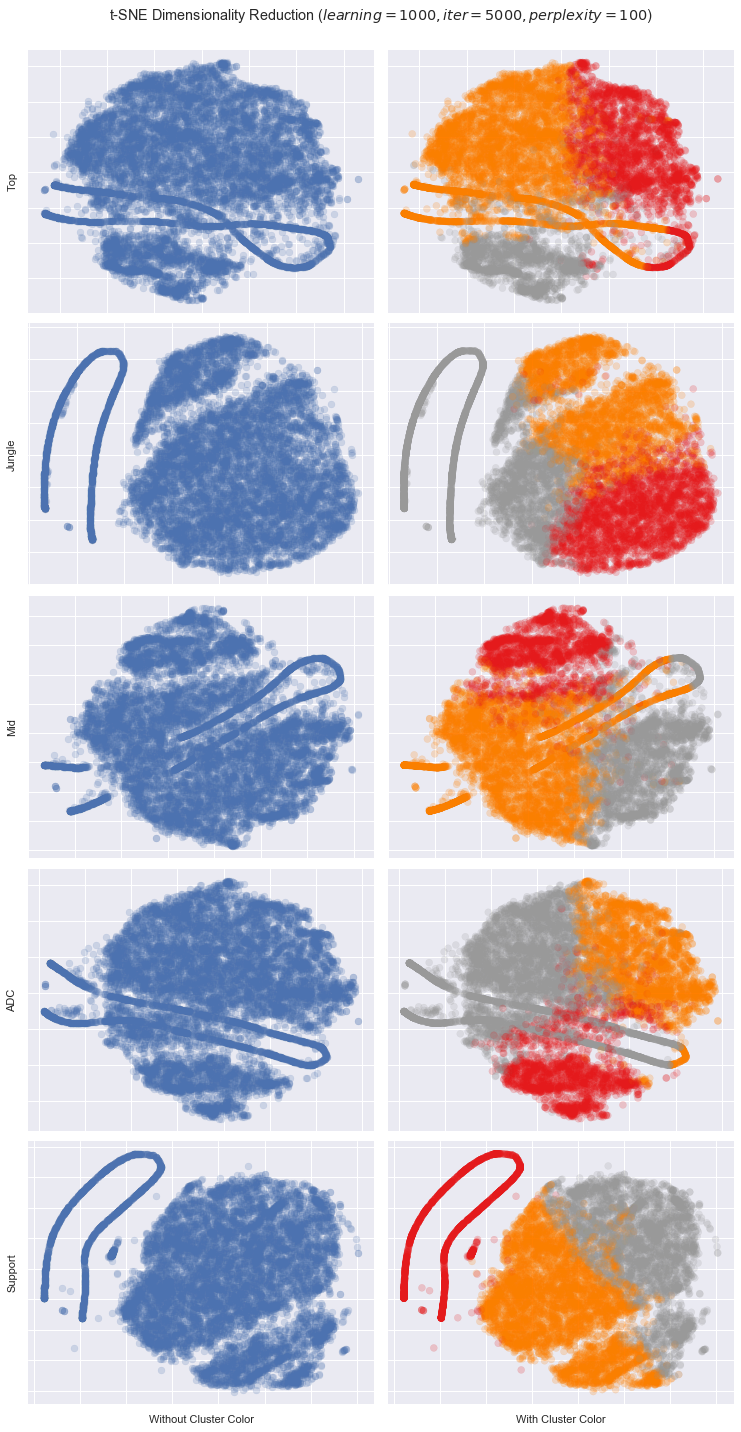

In [143]:
f, ((ax1, ax6), (ax2, ax7), (ax3, ax8), (ax4, ax9), (ax5, ax10)) = plt.subplots(5, 2, figsize=(10,20))
f.suptitle('t-SNE Dimensionality Reduction ($learning = 1000, iter = 5000, perplexity = 100$)')

for i, l in enumerate(['Top', 'Jungle', 'Mid', 'ADC', 'Support']):
    data = tsne_data[l]['L1000p100']
    eval('ax'+str(i+1)).scatter(data[:, 0], data[:, 1], alpha = .2)
    eval('ax'+str(i+1)).set_yticklabels([])
    eval('ax'+str(i+1)).set_xticklabels([])
    
    eval('ax'+str(i+6)).scatter(data[:, 0], data[:, 1], c = position_dfs[i].cluster,
                                cmap = plt.cm.get_cmap('Set1', k_count[i]), alpha = .2)
    eval('ax'+str(i+6)).set_yticklabels([])
    eval('ax'+str(i+6)).set_xticklabels([])

ax1.set_ylabel('Top')
ax2.set_ylabel('Jungle')
ax3.set_ylabel('Mid')
ax4.set_ylabel('ADC')
ax5.set_ylabel('Support')
ax5.set_xlabel('Without Cluster Color')
ax10.set_xlabel('With Cluster Color')
plt.subplots_adjust(left=.01, bottom=.01, right=.99, top=.95, wspace=.04, hspace=.04)
plt.show()

### Conclusions of review

The end determination of this process is that there should be 3 clusters for each position categorization.

**NOTE:** The method used to arrive at these cluster numbers struggled when deciding on jungle and support, but the assignments at the chosen numbers seemed the most sensible from the following visualizations. Oddly, before correcting the error I detected from last week, I was having the opposite problem, where jungle clusters had very clear splits up to 9 clusters.

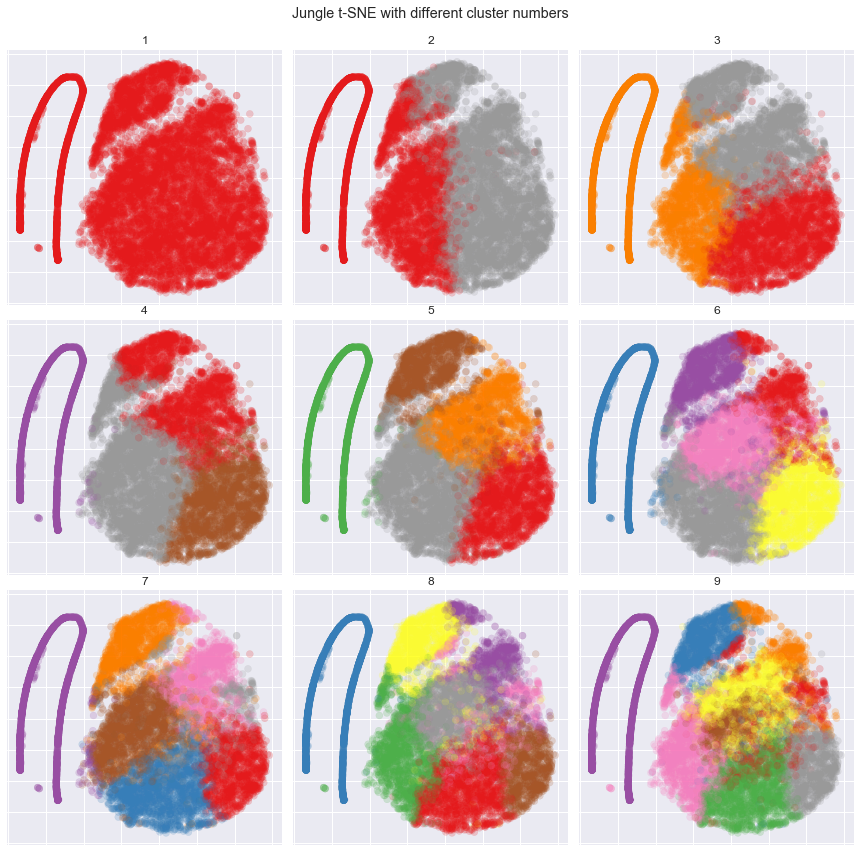

In [144]:
jung_display = [0 for i in range(10)]

for i in range(1,10):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(position_dfs[1].drop('cluster', axis = 'columns'))
    jung_display[i] = kmeans.labels_

f, ((ax1, ax2, ax3), (ax4, ax5,ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12,12))
f.suptitle('Jungle t-SNE with different cluster numbers')
data = tsne_data['Jungle']['L1000p100']

for i in range(1,10):
    eval('ax'+str(i)).scatter(data[:, 0], data[:, 1], c = jung_display[i],
                                cmap = plt.cm.get_cmap('Set1', i), alpha = .2)
    eval('ax'+str(i)).set_yticklabels([])
    eval('ax'+str(i)).set_xticklabels([])
    eval('ax'+str(i)).set_title(str(i))

plt.subplots_adjust(left=.01, bottom=.01, right=.99, top=.93, wspace=.04, hspace=.06)
plt.show()

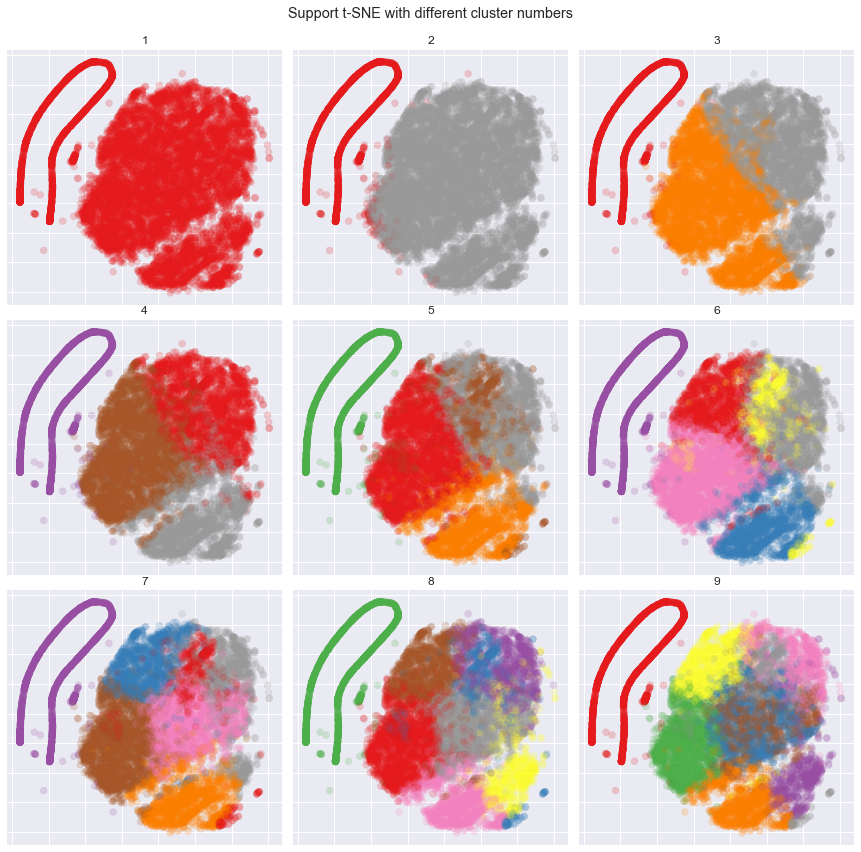

In [145]:
sup_display = [0 for i in range(10)]

for i in range(1,10):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(position_dfs[4].drop('cluster', axis = 1))
    sup_display[i] = kmeans.labels_

f, ((ax1, ax2, ax3), (ax4, ax5,ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12,12))
f.suptitle('Support t-SNE with different cluster numbers')
data = tsne_data['Support']['L1000p100']

for i in range(1,10):
    eval('ax'+str(i)).scatter(data[:, 0], data[:, 1], c = sup_display[i],
                                cmap = plt.cm.get_cmap('Set1', i), alpha = .2)
    eval('ax'+str(i)).set_yticklabels([])
    eval('ax'+str(i)).set_xticklabels([])
    eval('ax'+str(i)).set_title(str(i))

plt.subplots_adjust(left=.01, bottom=.01, right=.99, top=.93, wspace=.04, hspace=.06)
plt.show()

## Interpretting the clusters

I'll bring back my helper function to take a look at which features are the driving forces behind the cluster assignments.

In [279]:
def get_cluster_factors(df, spread = 1):
    dummies = [f for f in list(df) if 'champion_' in f]
    sd = df.std()
    g = df.drop(dummies, axis = 'columns').groupby('cluster').mean()
    big_factors = [(c, (max(g[c]) - min(g[c]))/sd[c]) for c in g if max(g[c]) - min(g[c]) >= spread*sd[c]]
    big_factors = [(b[0], float("{0:.3f}".format(b[1]))) for b in big_factors]
    return sorted(big_factors, reverse = True, key=lambda x: x[1])

In [287]:
def get_unit_cluster_factors(df, spread = 1):
    dummies = [f for f in list(df) if 'champion_' in f]
    g = df.drop(dummies, axis = 'columns').copy()
    g.drop('cluster', axis = 1).loc[:,:] = StandardScaler().fit_transform(g.drop('cluster', axis =1))
    g = g.groupby('cluster').mean()
    big_factors = [(c, (max(g[c]) - min(g[c]))) for c in g if max(g[c]) - min(g[c]) >= spread]
    big_factors = [(b[0], float("{0:.3f}".format(b[1]))) for b in big_factors]
    return sorted(big_factors, reverse = True, key=lambda x: x[1])

### Interpretting clusters (cont'd)

I'll feed each of the positional dataframes into my helper function to see which features differed by more than one standard deviation across clusters.

In [147]:
for label,df in zip(['Top', 'Jungle', 'Mid', 'ADC', 'Support'], position_dfs):
    print(label,'--')
    print(get_cluster_factors(df), '\n')

Top --
[('fttime', 2.147), ('gamelength', 1.424), ('fdtime', 1.344), ('fbarontime', 1.292)] 

Jungle --
[('monsterkillsenemyjungle', 1.959), ('wcpm', 1.583), ('monsterkillsownjungle', 1.523), ('fbarontime', 1.044)] 

Mid --
[('fttime', 2.033), ('gamelength', 1.406), ('fdtime', 1.337), ('fbarontime', 1.312)] 

ADC --
[('fttime', 2.075), ('fdtime', 1.363), ('gamelength', 1.337), ('fbarontime', 1.231)] 

Support --
[('monsterkillsownjungle', 2.533), ('wpm', 2.445), ('wardshare', 2.416), ('earnedgoldshare', 2.313), ('dmgshare', 1.966), ('monsterkillsenemyjungle', 1.792), ('fbarontime', 1.436), ('wcpm', 1.355), ('gamelength', 1.323)] 



In [280]:
for label,i in zip(['Top', 'Jungle', 'Mid', 'ADC', 'Support'], range(5)):
    print(label,'--')
    print(get_cluster_factors(position_dfs[i], .5), '\n')

Top --
[('fttime', 2.147), ('gamelength', 1.424), ('fdtime', 1.344), ('fbarontime', 1.292), ('wardshare', 0.609), ('monsterkillsownjungle', 0.609), ('dmgshare', 0.581), ('fbtime', 0.577)] 

Jungle --
[('monsterkillsenemyjungle', 1.959), ('wcpm', 1.583), ('monsterkillsownjungle', 1.523), ('fbarontime', 1.044), ('gamelength', 0.906), ('fttime', 0.659), ('wpm', 0.63)] 

Mid --
[('fttime', 2.033), ('gamelength', 1.406), ('fdtime', 1.337), ('fbarontime', 1.312), ('dmgshare', 0.942), ('monsterkillsownjungle', 0.807), ('wardshare', 0.633), ('fbtime', 0.605), ('earnedgoldshare', 0.531)] 

ADC --
[('fttime', 2.075), ('fdtime', 1.363), ('gamelength', 1.337), ('fbarontime', 1.231), ('monsterkillsownjungle', 0.917), ('earnedgoldshare', 0.824), ('dmgshare', 0.816), ('wardshare', 0.746), ('wcpm', 0.732), ('fbtime', 0.571)] 

Support --
[('monsterkillsownjungle', 2.533), ('wpm', 2.445), ('wardshare', 2.416), ('earnedgoldshare', 2.313), ('dmgshare', 1.966), ('monsterkillsenemyjungle', 1.792), ('fbaron

In [266]:
type(position_dfs[0])

pandas.core.frame.DataFrame

In [149]:
full_pos_DFs = {}
full_pos_DFs['Top'] = k_players.loc[k_players.position == 'Top', :].copy()
full_pos_DFs['Top']['cluster'] = position_dfs[0].cluster
get_cluster_factors(full_pos_DFs['Top'])

[('fttime', 2.147),
 ('xpat10', 1.718),
 ('oppxpat10', 1.699),
 ('gamelength', 1.424),
 ('fdtime', 1.344),
 ('fbarontime', 1.292),
 ('minionkills', 1.259),
 ('goldspent', 1.197),
 ('totalgold', 1.19),
 ('wards', 1.081)]

In [274]:
full_pos_DFs['Top'].groupby('cluster').mean()['result']

cluster
0    0.503311
1    0.499056
2    0.497672
Name: result, dtype: float64

In [275]:
for i,pos in enumerate(['Jungle', 'Middle', 'ADC', 'Support']):
    full_pos_DFs[pos] = k_players.loc[k_players.position == pos, :].copy()
    full_pos_DFs[pos]['cluster'] = position_dfs[i+1].cluster

In [293]:
# from previous vif testing - but with ['oppxpat10', 'oppgoldat10', 'oppgoldat15']
# still included among columns
player_vif_inflators = ['result','elementals',
                        'side_Blue', 'monsterkills', 'wards', 'dmgtochamps', 'minionkills',
                       'ckpm', 'k', 'wardkills', 'totalgold', 'earnedgpm', 'teamdragkills',
                        'visionwardbuys', 'visionwards', 'teamdeaths']

for k in full_pos_DFs.keys():
    cols = list(set(list(full_pos_DFs[k])) - set(player_vif_inflators))
    print(k, ':\n', get_cluster_factors(full_pos_DFs[k].loc[:, cols], .6), '\n')

Top :
 [('fttime', 2.147), ('xpat10', 1.718), ('oppxpat10', 1.699), ('gamelength', 1.424), ('fdtime', 1.344), ('fbarontime', 1.292), ('goldspent', 1.197), ('cspm', 0.698), ('dmgtochampsperminute', 0.691), ('monsterkillsownjungle', 0.609), ('wardshare', 0.609)] 

Jungle :
 [('monsterkillsenemyjungle', 1.959), ('wcpm', 1.583), ('monsterkillsownjungle', 1.523), ('pentas', 1.162), ('fbarontime', 1.044), ('gamelength', 0.906), ('goldspent', 0.871), ('oppelementals', 0.862), ('fttime', 0.659), ('airdrakes', 0.649), ('wpm', 0.63), ('cspm', 0.612)] 

Middle :
 [('fttime', 2.033), ('gamelength', 1.406), ('fdtime', 1.337), ('fbarontime', 1.312), ('goldspent', 1.269), ('dmgshare', 0.942), ('monsterkillsownjungle', 0.807), ('goldat10', 0.767), ('oppgoldat10', 0.693), ('dmgtochampsperminute', 0.642), ('wardshare', 0.633), ('fbtime', 0.605)] 

ADC :
 [('fttime', 2.075), ('fdtime', 1.363), ('goldspent', 1.344), ('gamelength', 1.337), ('fbarontime', 1.231), ('monsterkillsownjungle', 0.917), ('dmgtocha

In [277]:
for k in full_pos_DFs.keys():
    print(k, ':\n',
          full_pos_DFs[k].groupby("cluster")['result'].agg([np.mean, 'count']).rename(columns={"mean": "win_pct"}), '\n')

Top :
           win_pct  count
cluster                 
0        0.503311   3020
1        0.499056   5829
2        0.497672   1933 

Jungle :
           win_pct  count
cluster                 
0        0.569348   3158
1        0.494037   3522
2        0.451731   4102 

Middle :
           win_pct  count
cluster                 
0        0.495073   2131
1        0.498776   5718
2        0.505967   2933 

ADC :
           win_pct  count
cluster                 
0        0.502524   2179
1        0.509983   2955
2        0.493803   5648 

Support :
           win_pct  count
cluster                 
0        0.498884   1792
1        0.493293   5293
2        0.510143   3697 



**NOTE:** While playing with the number of jungle clusters, 4 and 5 each put about 2k observations in the winner group, and 3k in the loser. 6 clusters resulted in 2k in the winner group but split the loser group into big losers (.42, 1.7k) and slight losers (.48, 1.8k). 7 clusters reduced the winners (.58) to 1.7k and losers (.42) to 1.6k.

In [49]:
def get_per_cluster_factors(df, spread = 1):
    sd = df.std()
    non_num = ['patchno','side','position','team','champion', 'cluster']
    cols = list(df.drop(non_num, axis = 'columns', errors = 'ignore'))
    groups = df.groupby('cluster')
    for i,d1 in groups:
        big_factors = []
        g1 = d1.mean()
        for j,d2 in groups:
            if i!=j:
                g2 = d2.mean()
                for c in cols:
                    if g1[c] - g2[c] >= spread*sd[c]:
                        big_factors.append((c, float("{0:.3f}".format((g1[c] - g2[c])/sd[c])), 'Above group {}'.format(j)))
        print('Group', i)
        print(sorted(big_factors, reverse = True, key=lambda x: x[1]), '\n')

In [59]:
for k in full_pos_DFs.keys():
    cols = list(set(list(full_pos_DFs[k])) - set(player_vif_inflators))
    print(k)
    get_per_cluster_factors(full_pos_DFs[k].loc[:, cols], .6)

Top
Group 0
[('fttime', 1.781, 'Above group 2'), ('xpat10', 1.467, 'Above group 2'), ('oppxpat10', 1.455, 'Above group 2'), ('fdtime', 0.866, 'Above group 2'), ('wardshare', 0.609, 'Above group 2')] 

Group 1
[('fttime', 2.146, 'Above group 2'), ('xpat10', 1.714, 'Above group 2'), ('oppxpat10', 1.694, 'Above group 2'), ('gamelength', 1.425, 'Above group 0'), ('fdtime', 1.347, 'Above group 2'), ('fbarontime', 1.293, 'Above group 0'), ('goldspent', 1.198, 'Above group 0'), ('gamelength', 0.819, 'Above group 2'), ('goldspent', 0.756, 'Above group 2'), ('cspm', 0.698, 'Above group 2'), ('dmgtochampsperminute', 0.69, 'Above group 2'), ('fbarontime', 0.602, 'Above group 2')] 

Group 2
[('fbarontime', 0.691, 'Above group 0'), ('monsterkillsownjungle', 0.606, 'Above group 0'), ('gamelength', 0.606, 'Above group 0')] 

Jungle
Group 0
[('pentas', 1.007, 'Above group 1'), ('pentas', 1.007, 'Above group 2')] 

Group 1
[('monsterkillsenemyjungle', 1.972, 'Above group 0'), ('monsterkillsenemyjungle'

In [305]:
def show_cluster_factors(df, spread=1, full_scale = False):
    player_vif_inflators = ['result',
                             'monsterkills', 'wards', 'dmgtochamps', 
                            'k', 'wardkills', 'totalgold',
                            'visionwardbuys', 'visionwards']
    factor_cols = list(set(list(df)) - set(player_vif_inflators))
    cols = get_cluster_factors(df[factor_cols], spread)
    cols = [c[0] for c in cols]
    g = df[cols]
    sd = g.std()
    mu = 0
    if full_scale:
        mu = g.mean()
    
    ax = ((g.groupby(df.cluster)[cols].mean() - mu)/sd).transpose().plot(kind = 'bar', rot = 45, figsize=(20, 10))
    ax.tick_params(axis = 'x', labelsize = 14)
    ax.set_title(df.position.iloc[0])
    ax.title.set_fontsize(20)
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')

    plt.show()
    
#     ['result','elementals',
#                             'side_Blue', 'monsterkills', 'wards', 'dmgtochamps', 'minionkills',
#                            'ckpm', 'k', 'wardkills', 'totalgold', 'earnedgpm', 'teamdragkills',
#                             'visionwardbuys', 'visionwards', 'teamdeaths']

In [218]:
def top_champs(df, n=5):
    return df.groupby('cluster').champion.apply(lambda x: round((x.value_counts()/x.size).head(n), 4)*100)

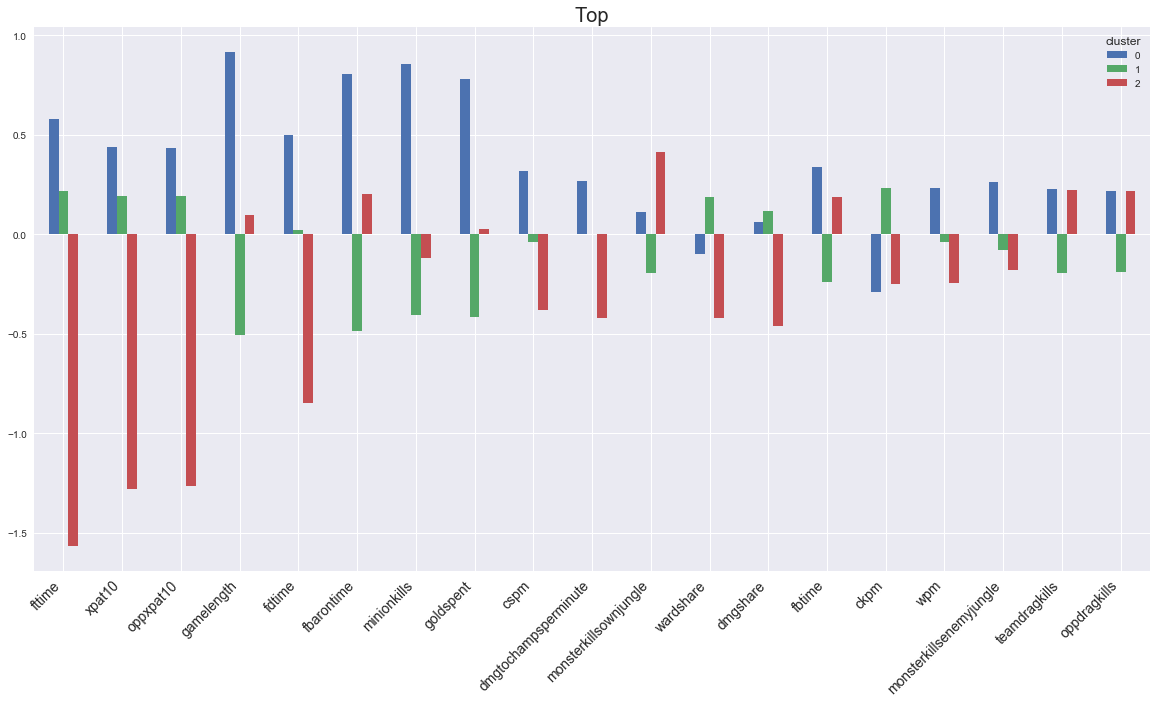

In [306]:
show_cluster_factors(full_pos_DFs['Top'], .4, full_scale = True)

I think that cluster 0 is depicting split-pushers or split-push counters due to the longest game length, high dmgshare, highest xp for them and opponent (because opponent must spend more time in lane contesting their push), high dmg to champs (because they are often on an island with their lane opponent), slowest baron and first dragon time (because regardless who claims them, the split-push team's goal is to contest and stall neutral objectives while their split-pusher pressures another side of the map). In addition to split-pushing, this cluster can more generally represent a safe, conservative approach to gameplay.

Cluster 1 I think may be a mix of assassins, tanks, and bruisers - basically, skirmish focused. Their high ward share represents constant roaming, relatively high xp due to kills and assists in team fights, but lower cspm than the split-pushers. Additionally, the fastest baron time and shortest game length suggests that the constant skirmishing leads to one side snowballing ahead of the other.

My instinct is to say cluster 2 is showing top laners in lane swap games, due to the very early first turret time, and high number of of own jung monsters killed. Top laners in lane swaps also fall behind in xp as reflected by both the player's and opponent's xp at 10 being extremely low. My hesitation is that lane swaps from my understanding, accelerated the pace of the game, but this does not appear to be the case here. But the top laner being disadvantaged by the lane swap meta is reflected in their dmgshare, dmg per minute, and cspm. Lane swaps tended to favor tanks in the top lane because they were better equipped to hold their turret longer and were more able to contribute in team fights if behind in farm, so that could also be influencing dmgshare. Beyond lane swap games, this cluster likely also shows top laners deferring resources/farm for other members of their team.

I'll look at the most played champions in the clusters to see how well they confirm or rebuke these interpretations.

In [219]:
top_champs(full_pos_DFs['Top'], 10)

cluster           
0        Shen          9.83
         Maokai        8.94
         Rumble        7.91
         Gnar          6.59
         Nautilus      6.42
         Poppy         6.36
         Ekko          4.93
         Renekton      4.87
         Jarvan IV     4.34
         Trundle       4.27
1        Maokai        9.47
         Shen          8.87
         Rumble        8.01
         Gnar          6.40
         Nautilus      6.33
         Renekton      6.06
         Jarvan IV     5.46
         Poppy         4.99
         Gragas        4.13
         Camille       3.91
2        Trundle      10.19
         Shen         10.19
         Maokai       10.09
         Poppy         9.26
         Gnar          8.23
         Nautilus      5.54
         Ekko          5.38
         Irelia        5.33
         Fiora         4.66
         Gangplank     4.14
Name: champion, dtype: float64

In general, I think these champion counts support my interpretation of the clusters.
- Group 0 has tanks to slow down a split push as well as strong early and mid game champions to get an advantage in lane.
- Group 1 is similar to Group 0 but has more reliable crowd control for team fights and skirmishes.
- Group 2 has a mix - the most played champions are ones that can be useful with low resources (especially Trundle, who has an ability to temporarily take the attributes of his chosen target). The lesser played half is made up of strong scaling champions. This could represent teams opting for late-game insurance if the game drags out, but more likely suggests another wrinkle - Opponents putting heavy focus on denying the farm of these strong scalers and deliberately accelerating the pace of the game. Rather than lane swap, this means the more appropriate label for this group will be 'low-resource'.

It's interesting to see Shen as one of the most played in every style, but that makes sense as his mix of team-fighting and global map presence allows him to play in or against multiple styles. Tanks in general are common across all 3 groups, as they have the versatility to work with multiple playstyles.

In [251]:
full_pos_DFs['Top'].loc[full_pos_DFs['Top'].cluster == 0, 'playstyle'] = 'split-push'
full_pos_DFs['Top'].loc[full_pos_DFs['Top'].cluster == 1, 'playstyle'] = 'skirmish'
full_pos_DFs['Top'].loc[full_pos_DFs['Top'].cluster == 2, 'playstyle'] = 'low-resource'

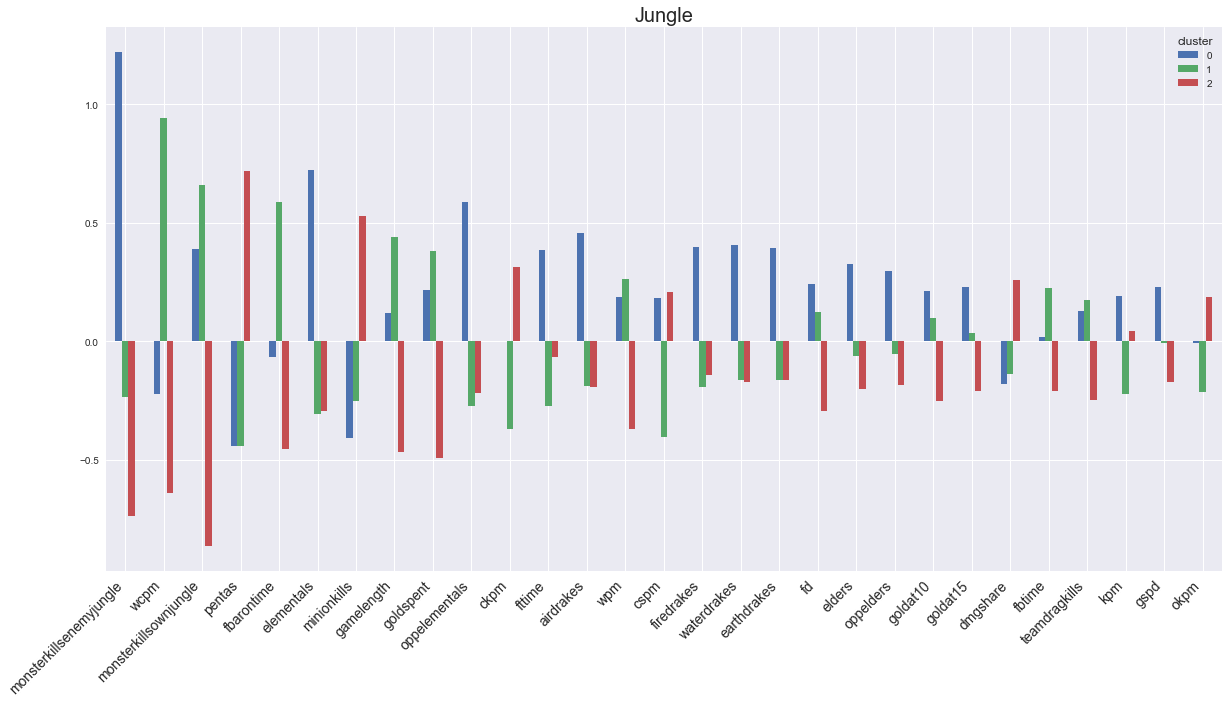

In [307]:
show_cluster_factors(full_pos_DFs['Jungle'], .4, full_scale = True)

**NOTE:** These jungle interpretation will likely change when I change features to cluster jungle on, since these groups currently do not have an even win rate, and cannot be as objectively interpretted. For these present clusters, win rates for groups 0, 1, 2 are 56.9%, 49.4%, and 45.1%.

Group 0 looks like it prioritizes counter jungling and early game control. As seen by its high rate of enemy jungle monster kills, dragon control, and middling baron time and game length. The low ward clear rate feels contrary to this playstyle, but may be a reflection of the player's opponent not have the space to place as many wards. There is also something strange going on with the high level of opponent elementals that I cannot similarly explain.

Group 1 looks like it is focused on defensive/safe jungling by the high ward clear, own jungle kills, late baron time, slow game speed, and low farm speed.

Group 2 looks to be all about gankers and carry junglers. They go for constant lane presence and whether successful or not, accelerate the pace of the game. Hence they have very low jungle monster kills, but high minion kills and dmgshare. Although it should be noted that because this is representing the 'loser' group (and because these junglers on average have low kpm and high okpm), those differences in gamespeed, minion kills, and dmg share could be reflecting that their team's damage dealers are struggling and the jungler is in lane getting minion kills while their laner is dead. For now, I'll euphemistically call this group 'lane-focused'.

In [254]:
top_champs(full_pos_DFs['Jungle'], 10)

cluster           
0        Lee Sin      15.36
         Kha'zix      15.20
         Rek'Sai      11.94
         Elise        11.59
         Graves       11.49
         Rengar       10.42
         Gragas        8.93
         Nidalee       3.32
         Olaf          2.31
         Zac           2.15
1        Elise        19.53
         Rek'Sai      18.20
         Gragas       15.90
         Graves       10.14
         Nidalee       9.31
         Kindred       6.02
         Lee Sin       5.25
         Olaf          2.92
         Kha'zix       2.10
         Hecarim       1.82
2        Gragas       15.07
         Elise        14.77
         Rek'Sai      11.48
         Graves       10.07
         Lee Sin       9.43
         Kha'zix       6.48
         Kindred       3.80
         Sejuani       3.56
         Jarvan IV     3.14
         Rengar        3.07
Name: champion, dtype: float64

These frequencies mostly reflect the theorized group splits:
- Group 0 - Early game bullies, great at invading and ganking.
- Group 1 - Has a mix of strong early game junglers that are hard to invade if farming with strong escapes, as well as scaling junglers that would want to play defensively.
- Group 2 - Most of the top picks here either have strong CC for ganking and counter ganking, or high dmg output.

In [300]:
full_pos_DFs['Jungle'].loc[full_pos_DFs['Jungle'].cluster == 0, 'playstyle'] = 'invasive'
full_pos_DFs['Jungle'].loc[full_pos_DFs['Jungle'].cluster == 1, 'playstyle'] = 'defensive'
full_pos_DFs['Jungle'].loc[full_pos_DFs['Jungle'].cluster == 2, 'playstyle'] = 'lane-focused'

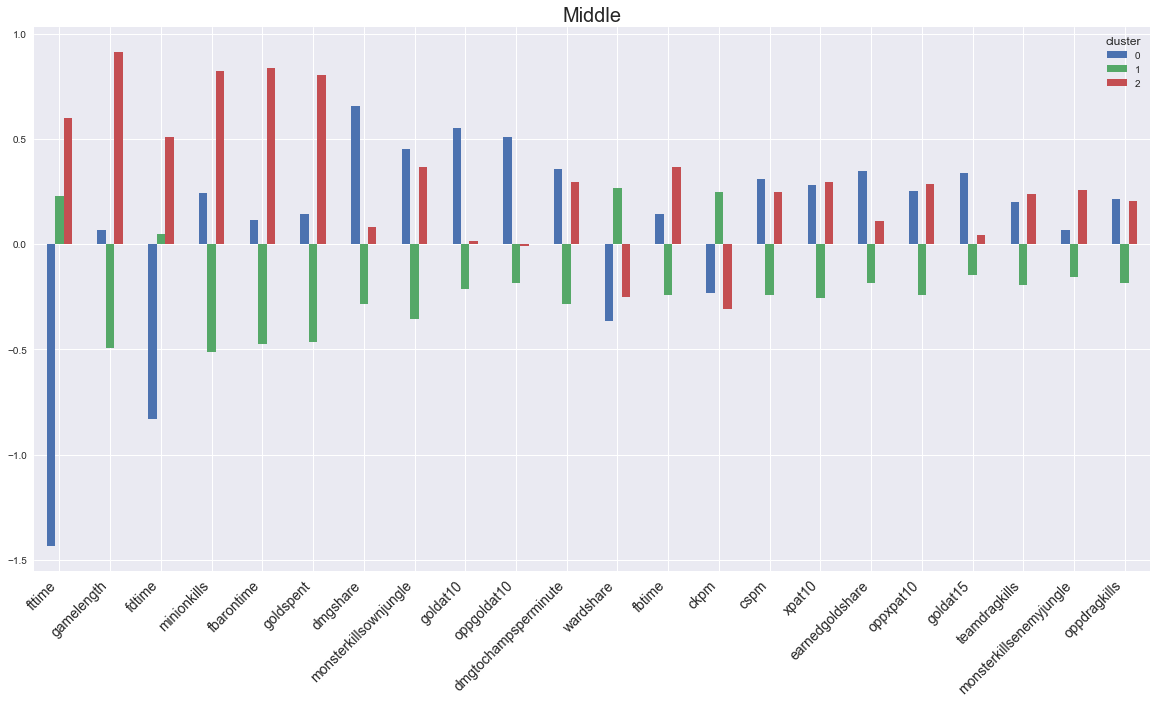

In [308]:
show_cluster_factors(full_pos_DFs['Middle'], .4, full_scale= True)

Group 0 looks mid-centric selections by its teams. These mid laners have much higher dmg and gold share than the other groups, while not being responsible for wardshare. I think this group is likely made up of assassins that require jungle presence around their lane to gain an advantage, or wave-clear powerhouses that also require jungle proximity to set up vision and protect them from ganks. The extremely early first turret and first drake suggests that either their sidelanes are surrendering pressure because of that jungle proximity, or the mid-laner is roaming early to snowball the sidelanes. Whatever way it's happening, the consistent theme of this group is 'mid-priority'.

Group 1 is all about getting things rolling in the early game. Fastest game and baron time, the lowest farm, and highest combined kills per minute and ward share. Whether these characters are assassins looking for picks, team fighters looking to force fights around the objective, or roamers, the pace of the game will accelerate. 'skirmishers'

Group 2 has the longest gamelength, and longest delay on all major objectives along with strong farming. Despite a high dmgtochampsperminute, they have low damage share and the games have low ckpm, which suggests these players are wave-clearing and poking/skirmishing to contest vision and objectives, but not being asked to carry their teams. These are 'control mages' keeping the game within reach to allow their top and/or adc to scale and carry.

In [304]:
top_champs(full_pos_DFs['Middle'], 10)

cluster            
0        Viktor        12.62
         Azir          10.46
         Corki          7.18
         LeBlanc        6.05
         Vladimir       5.82
         Lissandra      5.30
         Ryze           4.46
         Cassiopeia     4.22
         Orianna        3.80
         Syndra         3.61
1        Orianna        9.62
         Syndra         7.96
         Corki          7.14
         Taliyah        7.12
         Cassiopeia     6.51
         Viktor         6.09
         Ryze           5.91
         LeBlanc        5.91
         Vladimir       4.04
         Azir           3.32
2        Orianna        9.55
         Corki          9.07
         Syndra         8.90
         Viktor         7.47
         Taliyah        7.23
         Cassiopeia     5.66
         LeBlanc        5.08
         Vladimir       4.94
         Ryze           4.67
         Ahri           3.14
Name: champion, dtype: float64

In [319]:
full_pos_DFs['Middle'].loc[full_pos_DFs['Middle'].cluster == 0, 'playstyle'] = 'mid-priority'
full_pos_DFs['Middle'].loc[full_pos_DFs['Middle'].cluster == 1, 'playstyle'] = 'skirmish'
full_pos_DFs['Middle'].loc[full_pos_DFs['Middle'].cluster == 2, 'playstyle'] = 'control mage'

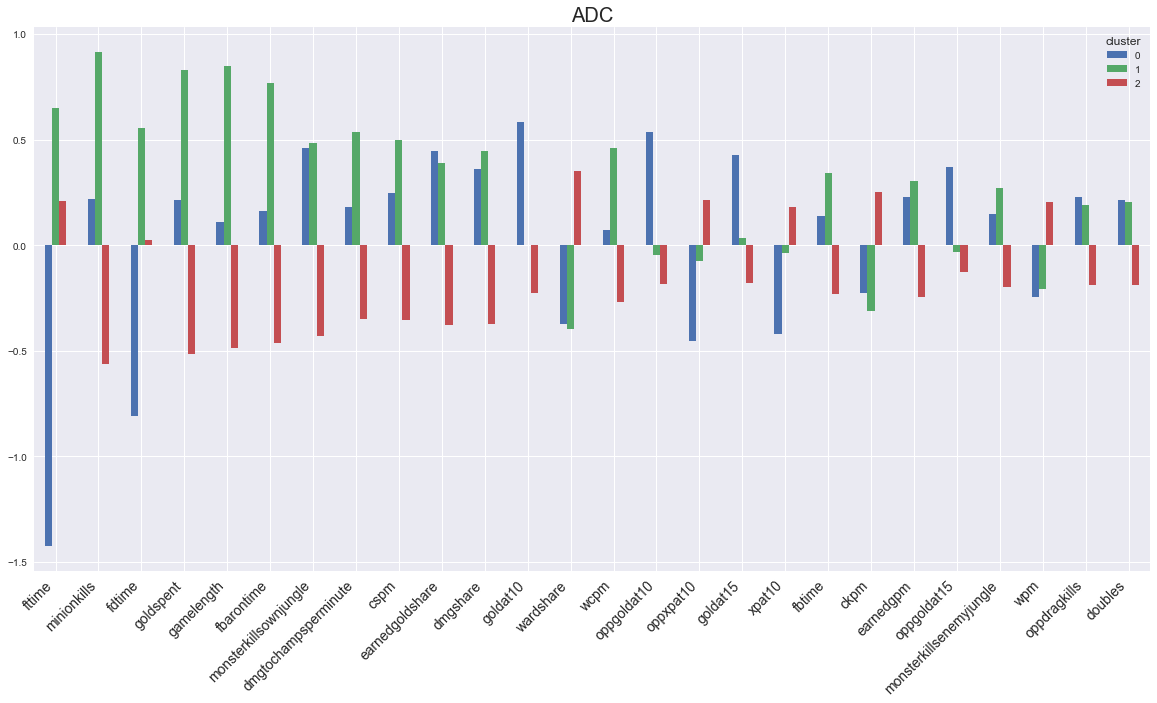

In [321]:
show_cluster_factors(full_pos_DFs['ADC'], .4, full_scale=True)

Group 0 looks like another lane-swap group. Incredibly early first turret and drake, highest early game gold despite lowest experience. It's not an early game adc or bot-lane priority because the high gold with low xp doesn't support that. Also I peaked ahead and saw this group had by far the highest playrate for Lucian, who was only really a meta ADC during the lane-swap era.

Group 1 looks like 'late-game' ADC's. They are heavily focused on farm, while their team delays the game - slow objective times, low ckpm. High dmgtochampsperminute despite slowest gametime suggests that these champions are being heavily protected by their team to deal out tremendous late-game damage.

Group 2 appear to be early game skirmishers. Fast game speed, fast objectives, low farm, high warding and ckpm with low opponent elementals. These ADC's are taking a 'utility' role to sacrifice farm and support their team in the early game.

In [323]:
top_champs(full_pos_DFs['ADC'], 10)

cluster          
0        Lucian      18.27
         Sivir       14.46
         Ezreal      12.16
         Ashe        10.92
         Jhin         9.04
         Kalista      8.44
         Caitlyn      8.12
         Corki        3.44
         Varus        3.44
         Tristana     3.21
1        Ashe        13.60
         Jhin        12.28
         Varus       11.13
         Caitlyn      9.98
         Ezreal       9.51
         Lucian       9.48
         Sivir        8.97
         Kalista      6.13
         Tristana     5.65
         Xayah        4.47
2        Ashe        15.28
         Jhin        12.61
         Varus       10.94
         Kalista      8.73
         Caitlyn      8.52
         Ezreal       8.34
         Lucian       8.14
         Sivir        7.70
         Tristana     4.78
         Xayah        4.39
Name: champion, dtype: float64

In [324]:
full_pos_DFs['ADC'].loc[full_pos_DFs['ADC'].cluster == 0, 'playstyle'] = 'lane-swap'
full_pos_DFs['ADC'].loc[full_pos_DFs['ADC'].cluster == 1, 'playstyle'] = 'late-game'
full_pos_DFs['ADC'].loc[full_pos_DFs['ADC'].cluster == 2, 'playstyle'] = 'utility'

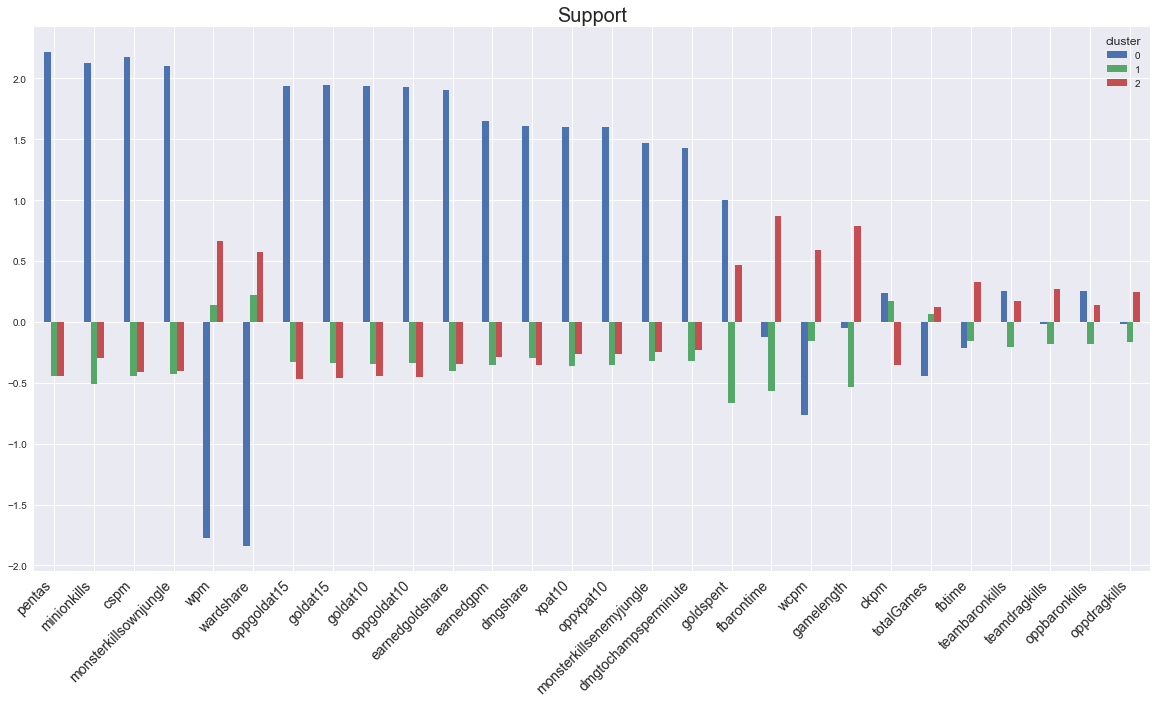

In [326]:
show_cluster_factors(full_pos_DFs['Support'], .4, full_scale = True)

This is one where my helper function is working against me. Because supports have such similar statistics to each other in most games, the variability of most features is quite low. So when supports end up having a couple thousand more gold or a couple dozen more cs than average, that becomes quite a few units of standard deviation, which in turn makes this differences appear much more severe than they really are. It would probably make sense to add/derive some features to cluster on with supports (as well as junglers). It would also be useful for interpretting the difference between support groups if after clustering I added some features to the Support DF that reflect ADC and enemy ADC performance.

I'll interpret the support results for now, but ultimately end up changing this entire section.

Group 0 represents 'offensive' supports. They're not focused on warding or objective control, but rather on farm and damage to champions.

Group 1 is another skirmisher group. Supports playing traditional roles, but in a fast paced game. 'skirmish'

Group 2 is focused on vision and objective control, trying to maintain a slow, methodic pace. 'map-control'

In [ ]:
list(playerDF)

In [ ]:
list(playerDF)

In [322]:
top_champs(full_pos_DFs['Support'], 10)

cluster            
0        Braum         17.52
         Thresh        11.22
         Alistar        9.54
         Lulu           9.43
         Karma          9.10
         Tahm Kench     7.09
         Bard           5.02
         Nami           4.52
         Trundle        4.41
         Rakan          4.35
1        Braum         16.85
         Thresh        11.34
         Alistar       10.67
         Karma         10.62
         Tahm Kench     5.97
         Lulu           5.52
         Zyra           5.23
         Bard           5.12
         Nami           3.65
         Rakan          3.33
2        Braum         14.20
         Karma         13.42
         Thresh         9.90
         Alistar        8.82
         Zyra           7.63
         Lulu           5.90
         Tahm Kench     5.68
         Bard           5.60
         Trundle        5.09
         Nami           4.35
Name: champion, dtype: float64

In [328]:
full_pos_DFs['Support'].loc[full_pos_DFs['Support'].cluster == 0, 'playstyle'] = 'offensive'
full_pos_DFs['Support'].loc[full_pos_DFs['Support'].cluster == 1, 'playstyle'] = 'skirmish'
full_pos_DFs['Support'].loc[full_pos_DFs['Support'].cluster == 2, 'playstyle'] = 'map-control'

In [337]:
%store full_pos_DFs

Stored 'full_pos_DFs' (dict)


In [336]:
# full_pos_DFs['Support'].reset_index().set_index(['gameid', 'team']).head()
for i in full_pos_DFs:
    print(i)

Top
Jungle
Middle
ADC
Support


**ALEX NOTES**:

- Keep documenting findings so you don't lose them and are able to explain them to others as you go deeper.
- Try to modularize code as much as possible to prevent duplication.
- Make use of new vis suite.

In [34]:
leaks = ['teamtowerkills', 'teamkills', 'fbaron', 'gspd', 'teambaronkills', 'teamdragkills',
         'a', 'firsttothreetowers', 'kpm', 'k', 'gdat15', 'teamWinRate', 'totalgold', 'doubles',
        'goldspent', 'totalGames', 'goldat15', 'triples', 'elementals', 'fbassist', 'airdrakes',
        'firedrakes', 'earthdrakes', 'elders', 'quadras', 'pentas', 'opptowerkills', 'teamdeaths',
        'oppbaronkills', 'oppdragkills', 'd', 'okpm', 'oppgoldat15', 'oppelementals', 'fbvictim',
        'oppelders', 'oppxpat10', 'waterdrakes', 'fb']

maybe = ['earnedgmp', 'firstmidouter', 'ft', 'herald', 'gdat10', 'dmgtochampsperminute',
         'xpdat10', 'dmgtochamps', 'fd', 'goldat10', 'monsterkills', 'xpat10', 'cspm', 'minionkills',
        'oppgoldat10', 'earnedgpm']

# from previous vif testing
player_vif_inflators = ['result', 'oppxpat10', 'oppgoldat15', 'oppgoldat10', 'elementals',
                        'side_Blue', 'monsterkills', 'wards', 'dmgtochamps', 'minionkills',
                       'ckpm', 'k', 'wardkills', 'totalgold', 'earnedgpm', 'teamdragkills',
                        'visionwardbuys', 'visionwards', 'teamdeaths']

loose_regs = list(set(list(tsneDF)) - set(leaks))
tight_regs = list(set(loose_regs) - set(maybe))

loose_regs = list(set(list(loose_regs)) - set(player_vif_inflators))
tight_regs = list(set(list(tight_regs)) - set(player_vif_inflators))

regs = tight_regs
print(regs)

['fbarontime', 'side_Red', 'fb', 'wpm', 'fttime', 'fbtime', 'gamelength', 'wardshare', 'monsterkillsownjungle', 'dmgshare', 'fdtime', 'waterdrakes', 'monsterkillsenemyjungle', 'wcpm', 'earnedgoldshare']


# Work in progress

In [ ]:
# top_clust = tops[['team','cluster']].copy()
# top_clust.reset_index(inplace = True)
# top_clust.set_index(['gameid','team'], inplace = True)
# top_clust.sort_index(inplace = True)
# top_clust.drop(['player'], axis = 'columns', inplace = True)
# top_clust = pd.get_dummies(top_clust, prefix = 'TopLane_')
# norm_teamDF = norm_teamDF.join(top_clust)

### Sidenote:

I mentioned that I would like to do an evaluation with more features at some point but only using observations that are considered close games by `gspd`. This would allow me to include otherwise 'leaky' features because they won't have the same impact on the final model. IE, having a top laner with a lot of deaths in one of these games may have been a strategic decision where a team sacrifices control of one side of the map in order to find advantages on the other side.

Unfortunately, there aren't a lot of close games to use in a model. So I'm curious what your thoughts are on this. How far can I stretch p-values to still call the games close if I want to expand the range of what I call close games. Or, if I maintain a small sample size, can I cheat it bigger with bootstrapping?

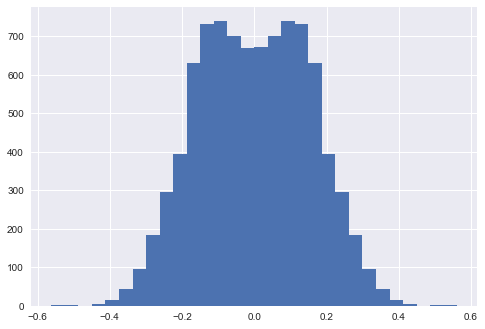

(25, 98)
0.48
Ttest_relResult(statistic=-0.19611613513818402, pvalue=0.84617037734608591)
Ttest_indResult(statistic=-0.19975041822311876, pvalue=0.84167953919130911)
Ttest_1sampResult(statistic=-0.19611613513818418, pvalue=0.8461703773460858)


In [134]:
teamDF.gspd.hist(bins = 30)
plt.show()

close_games = teamDF[(teamDF.gspd < 0) & (teamDF.gspd > -.001)]
print(close_games.shape)
print(close_games.result.mean())
print(stats.ttest_rel(close_games.result, teamDF[(teamDF.gspd > 0) & (teamDF.gspd < .001)].result))
print(stats.ttest_ind(close_games.result, teamDF.result))
print(stats.ttest_1samp(close_games.result, .5))

In [3]:
tsneDF = k_players.copy()
tsneDF.drop(['position','team','champion', 'patchno'], axis = 'columns', inplace = True)
tsneDF = pd.get_dummies(tsneDF, columns = ['side'])
m = tsneDF.max(axis = 0, numeric_only = True)
cats = list(m[m == 1].index)
nums = list(set(list(tsneDF)) - set(cats))
print('---- BEFORE SCALING ---- \n', tsneDF.iloc[:2,:8])
tsneDF.loc[:,nums] = StandardScaler().fit_transform(tsneDF.loc[:,nums])
print('\n ---- AFTER SCALING ---- \n',tsneDF.iloc[:2,:8])

---- BEFORE SCALING ---- 
                   gamelength  result  k  d   a  teamkills  teamdeaths  doubles
gameid  player                                                                
1000029 Chei       40.316667       1  1  2  15         18           8      0.0
        Flawless   40.316667       0  1  3   7          8          18      0.0

 ---- AFTER SCALING ---- 
                   gamelength  result         k         d         a  teamkills  \
gameid  player                                                                  
1000029 Chei        0.503994       1 -0.594972 -0.250135  2.227901   0.875717   
        Flawless    0.503994       0 -0.594972  0.311379  0.279601  -0.635386   

                  teamdeaths   doubles  
gameid  player                          
1000029 Chei       -0.638075 -0.392659  
        Flawless    0.871332 -0.392659  


In [146]:
def get_win_splits(data, pos, groups, rand = 10):
    for i in groups:
        df = data.copy()
        kmeans = KMeans(n_clusters = i, random_state = rand)
        kmeans.fit(df)
        df['cluster'] = kmeans.labels_
        df['result'] = k_players.loc[k_players.position == pos, 'result']

        print(i, ':\n',
              df.groupby("cluster")['result'].agg([np.mean, 'count']).rename(columns={"mean": "win_pct"}), '\n')